# Oppgave 3: Klyngeanalyse (20%)<a name="oppgave3"></a>

*Oppgave 3 består av 4 deler med til sammen 10 spørsmål, der alle spørsmål (3a.1), 3a.2) etc.) teller likt. Oppgave 3 teller totalt 20 % av prosjektet.*

**Oppgaven inneholder følgende elementer:**

* Laste inn og utforske et bilde, gjøre bildet om til et datasett for bruk i klyngeanalyse
* Bruk $K$-gjennomsnitt-klyngeanalyse får å finne klynger i bilder av håndskrevne tall. 
* Vise resultater fra klyngeanalysen - som bilde - og tolke resultatene
* Diskutere $K$-gjennomsnitt-klyngeanalyse vs. hierarkisk klynganalyse
* Utvide til flere klynger i $K$-gjennomsnitt-klyngeanalyse

## Innholdsfortegnelse
* [Introduksjon](#intro)
* [Oppgave 3a) Les inn datasettet og bli kjent med det](#oppgave3a)
* [Oppgave 3b) Klyngeanalyse med $K$-gjennomsnitt](#oppgave3b)
* [Oppgave 3c) Hierarkisk klyngeanalyse](#oppgave3c)
* [Oppgave 3d) Prediksjon](#oppgave3d)

### Finn klynger (struktur) i bildene av håndskrevne tall<a name="intro"></a>

Et stort felt innom maskinlæring er bildegjenkjenning (image recognition) og klassifisering. Dette betyr at vi vil laste inn et bilde til en statistisk algoritme, og får tilbake en etikett som beskriver hva bildet representerer, for eksempel en person, et tall eller en sykdom.

I denne oppgaven skal vi jobbe med data fra *mnist* (Modified National Institure of Standards and Technology) databasen, som for eksempel finnes her: https://www.kaggle.com/c/digit-recognizer. Datasettet inneholder digitaliserte bilder av handskrevne siffer (0-9), og dette pleier å bli brukt for å trene maskinlæringsalgoritmer for klassifisering (det betyr at du vil forutsi hvilket tall et bestemt bilde inneholder, slik at datamaskinen kan lese tall, for eksempel postnummer på et brev).

Her bruker vi dette datasettet til noe annet: Vi vil undersøke om vi finner struktur i bildene ved bruk av en klyngeanalyse. Vi vil jo kanskje håpe at de samme sifrene kommer til å bli gruppert i en klynge fordi de inneholder lignende mønstre. Her skal vi se om det er sant. 

Vi har lært om to populære algoritmer som brukes til å lage klynger av objekter: 

   * $K$-gjennomsnitt ($K$-means) algoritmen: Målet med denne algoritmen er å plassere de individuelle observasjonene i $K$ grupper (kalt klynger) basert på observasjonenes avstand til grupper av andre observasjoner. Algoritmen kjøres iterativt, og stoppes når at alle observasjoner som ligner hverandre er plassert i en gruppe (klynge) sammen.
   * Hierarkisk klyngeanalyse (se nedenfor).

**Vi skal kun se på 3 ulike siffer mellom 0 og 9.**

In [3]:
# importere pakker og funksjoner vi trenger i oppgave 3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans # k-gjennomsnitt klyngeanalyse
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

### Oppgave 3a) Les inn datasettet og bli kjent med det<a name="oppgave3a"></a>

*Oppgave 3a) inneholder 3 spørsmål du skal svare på.*

Vi begynner med å lese inn datasettet som inneholder informasjon om digitaliserte handskrevne siffer. Hvert siffer finnes i en firkant med $28\cdot 28$ = 784 pixler, og dermed er hvert bilde representert som en vektor med lengde 784.


In [4]:
# Leser inn datasettet og ser på de første 5 radene (tallene)

images = pd.read_csv('https://www.math.ntnu.no/emner/IST100x/ISTx1003/h2023/mnist_2023.csv', sep = ",", index_col = 0)

images.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V775,V776,V777,V778,V779,V780,V781,V782,V783,V784
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Å skrive ut headeren gir oss lite informasjon. Pikslene for disse bildene er gitt som et tall mellom 0 og 255 (gråskala), hvor 0 representerer helt svart og 255 representerer helt hvitt. Pikslene representert ovenfor er det øverste venstre hjørnet av bildet, og det nedre høyre hjørnet av bildet, som vi forventer ville være tomt (svart, og derfor 0).

Vi ønsker å standardisere disse tallene slik at de er mellom 0.0 og 1.0 før analysen utføres.

In [5]:
## standardisering av dataene
images = images/255

Vi vil vite litt om formatet til datasettet vårt, og skriver ut litt informasjon.

In [6]:
print("Bildet har type", type(images))
print("Størrelsen til tabellen er", images.shape)
# gjennomsnittfargen i bilde 50 (MERK: vi ber om bildet på plass 49, siden det første bildet er på plass 0)
print("Gjennomsnittsfarge i bilde 50 er", images.iloc[49].mean())
print('Dataformatet til en piksel er', type(images.iloc[1,1]))

Bildet har type <class 'pandas.core.frame.DataFrame'>
Størrelsen til tabellen er (6000, 784)
Gjennomsnittsfarge i bilde 50 er 0.15412164865946382
Dataformatet til en piksel er <class 'numpy.float64'>


Nå skal vi se på de første 10 tallene i datasettet vårt.

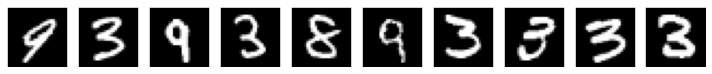

In [7]:
features = np.array(images)
features = features.reshape(features.shape[0], 28,28)

fig = plt.figure(figsize=(10,10))

for i in range(10):
    fig.add_subplot(1, 10, i+1)
    plt.imshow(features[i], cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Det er ganske enkelt for oss mennesker å gjenkjenne disse individuelle sifferene -- selv om håndskrift kan være ganske uleselig. Nå vil vi se hvor bra $K$-gjennomsnittsalgoritmen finner struktur i disse dataene.

**3a.1)** Hvilke 3 siffer har vi i datasettet? Hvor mange bilder har vi totalt i datasettet? 

**3a.2)** Hvilket siffer ligner det 500. bildet i datasettet vårt på? Lag et bilde som viser dette sifferet. (Husk at Python begynner nummereringen med 0, og derfor refereres det 500. bildet til `[499]`)

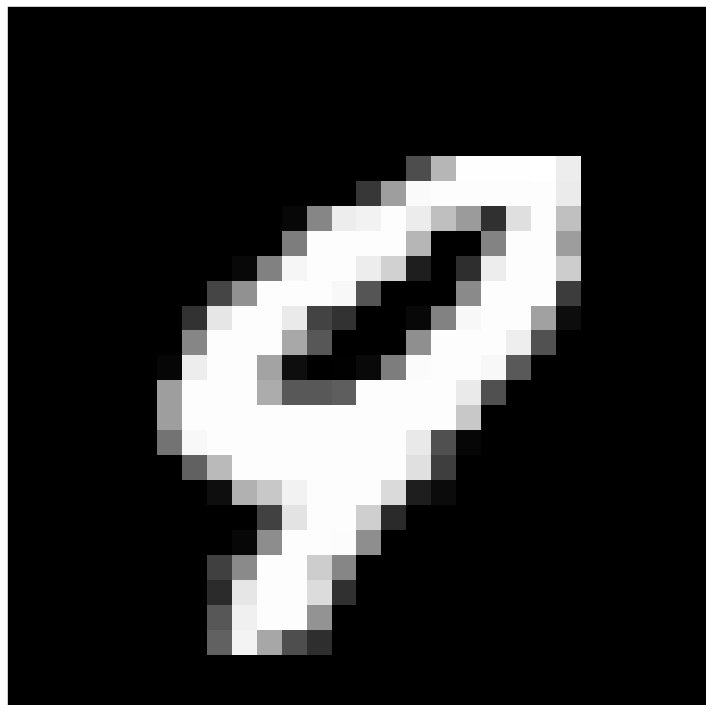

In [8]:
# her kan du lime inn og redigere kode for å plotte bildet
features = np.array(images)
features = features.reshape(features.shape[0], 28,28)

fig = plt.figure(figsize=(10,10))
plt.imshow(features[499], cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.tight_layout()

### Oppgave 3b) Klyngeanalyse med $K$-gjennomsnitt<a name="oppgave3b"></a>

*Oppgave 3b) inneholder 4 spørsmål du skal svare på.*

La oss nå utføre $K$-gjennomsnittalgoritme. Vi må gå gjennom følgende steg:

  1. Angi antall klynger du ønsker
  2. Initialiser $K$-gjennomsnitt-modellen
  3. Tilpass $K$-gjennomsnitt-modellen

Vi bruker $K$-gjennomsnittsfunksjonen med $K=3$ (se kode under), fordi vi håper jo å finne igjen de 3 sifferene i klyngene.

I tillegg kan vi få tilgang til sentroidene i klyngene våre i tabellen `means.cluster_centers_`, og plotte dem for å se hvordan algoritmen mener de typiske bildene i de $K$ gruppene ser ut.

Hint: Her kan du lese litt mer om KMeans-funksjonen: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans

In [29]:
# Antall klynger
antall_klynger = 4

# Initialiser k-gjennomsnittsalgoritmen
kmeans = KMeans(n_clusters=antall_klynger, random_state=1, n_init=10, init='k-means++')

# Tilpass modellen
tilpass = kmeans.fit(images)

# Få sentroidene
sentroider = kmeans.cluster_centers_

**3b.1)** Tegn sentroidene av de 3 klyngene fra $K$-gjennomsnitt modellen. Tilpass koden over for å plotte. Her kan du ta skjermbilde av sentroidene og lime inn i svararket. Hint: Sentroidene har samme format som dataene (de er 384-dimensjonale), og hvis de er representative vil de se ut som tall.

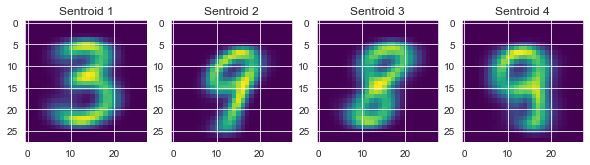

In [30]:
# Konverter sentroidene til et 28x28 bilde (for eksempel)
sentroid_bilder = sentroider.reshape((antall_klynger, 28, 28))

# Plot sentroidene som bilder
fig, axs = plt.subplots(1, antall_klynger, figsize=(10, 10))

for i in range(antall_klynger):
    axs[i].imshow(sentroid_bilder[i], cmap='viridis')
    axs[i].set_title(f'Sentroid {i + 1}')

plt.show()

**3b.2)** Synes du at grupperingen i klynger er relevant og nyttig? Forklar. Maks 3 setninger. 

**3b.3)** Vi har valgt $K = 3$ for dette eksempelet fordi vi vil finne klynger som representerer de 3 sifrene. Men generelt er $K$ vilkårlig. Kom opp med et forslag for hvordan man (generelt, ikke nødvendigvis her) best kan velge $K$. (Se her, for eksempel: https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb). Beskriv i egne ord med maks 3 setninger.

**3b.4)** Kjør analysen igjen med $K = 2$ og $K = 4$. Synes du de nye grupperingene er relevante?
 

In [ ]:
# her kan du kjøre analysen med K = 2 og K = 4 (kopier relevant kode og gjør endringer)

### Oppgave 3c) Hierarkisk klyngeanalyse<a name="oppgave3c"></a>

*Oppgave 3c) inneholder 3 spørsmål du skal svare på.*

Nå skal vi bruke hierarkisk klyngeanalyse for *mnist*-datasettet med 3 sifre. Vi gjør *Agglomerative Clustering* ved bruk av `sklearn.cluster` pakken. (Agglomerative Clustering er noe vi har lært om i undervisningen, men se også her hvis du har lyst til å vite mer: https://en.wikipedia.org/wiki/Hierarchical_clustering)

Fordi hierarkisk gruppering er tregt for store datasett, og særlig for grafiske data, tar vi et tilfeldig utvalg på 30 bilder fra det originale datasettet.

**3c.1)** Vurder dendrogrammet nedenfor. Synes du at den hierarkiske grupperingsalgoritmen har laget gode/meningfulle grupper av bildene? (Maks 3 setninger).

**3c.2)** I koden under har vi brukt gjennomsnittskobling (`method = 'average'`). Hvordan fungerer gjennomsnittskobling? (Maks 3 setninger).

**3c.3)** Velg en annen metode enn `'average'` til å koble klyngene sammen (vi har lært om dette i undervisningen, her heter de `single`, `complete` og `centriod`) og lag et nytt dendogram ved å tilpasse koden nedenfor. Ser det bedre/verre ut? (Maks 3 setninger).


In [32]:
n_image = 30

sample = images.sample(n = n_image, random_state = 2)

sampleimg = np.array(sample).reshape(sample.shape[0], 28,28)

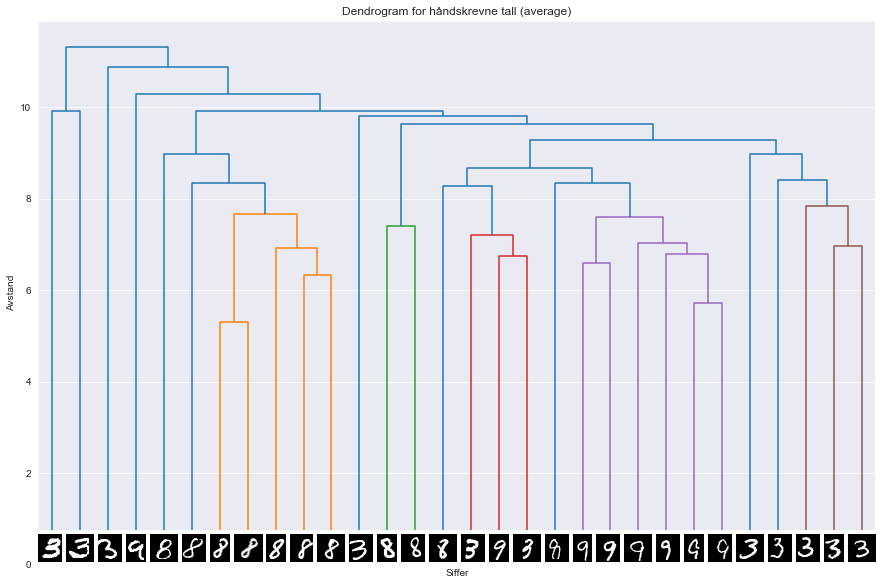

In [44]:
plt.figure(figsize=(15,10))
ax = plt.subplot()

# Bruk gjennomsnittskobling (method='average')
link = linkage(y = sample, method = 'average', metric = 'euclidean')

dendro = dendrogram(link)

dcoord = np.array(dendro["dcoord"])
icoord = np.array(dendro["icoord"])
leaves = np.array(dendro["leaves"])

idx = np.argsort(dcoord[:, 2])

dcoord = dcoord[idx, :]
icoord = icoord[idx, :]

idx = np.argsort(link[:, :2].ravel())
label_pos = icoord[:, 1:3].ravel()[idx][:n_image]

for i in range(n_image):
    imagebox = OffsetImage(sampleimg[i], cmap = 'gray', interpolation = "bilinear")
    ab = AnnotationBbox(imagebox, (label_pos[i], 0),  box_alignment=(0.5, -0.1), 
                        bboxprops={"edgecolor" : "none"})
    ax.add_artist(ab)

plt.title('Dendrogram for håndskrevne tall (average)')
plt.xlabel('Siffer')
plt.ylabel('Avstand')
plt.xticks([])
plt.show()

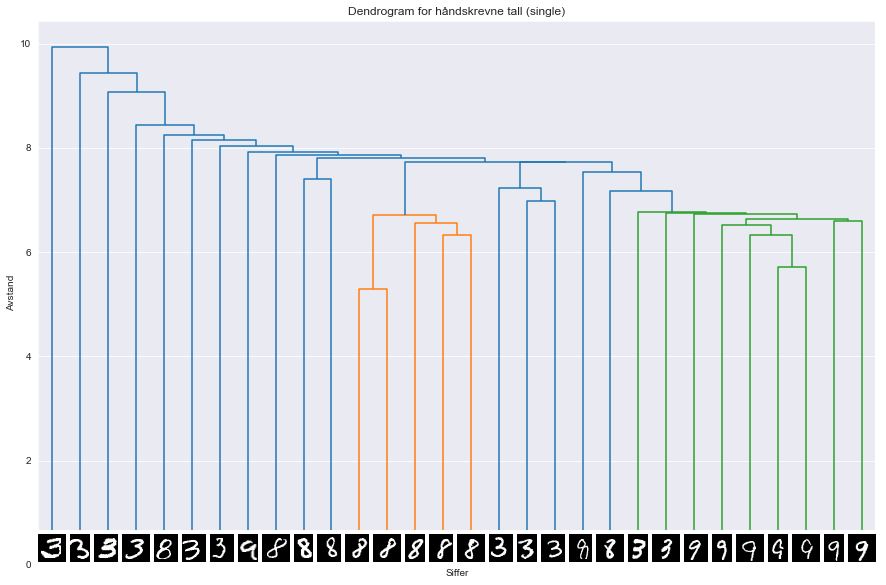

In [43]:
# her kan du lage et nytt dendrogram med ny 'method' (kopier koden over)
plt.figure(figsize=(15,10))
ax = plt.subplot()

# Bruk single
link = linkage(y = sample, method = 'single', metric = 'euclidean')

dendro = dendrogram(link)

dcoord = np.array(dendro["dcoord"])
icoord = np.array(dendro["icoord"])
leaves = np.array(dendro["leaves"])

idx = np.argsort(dcoord[:, 2])

dcoord = dcoord[idx, :]
icoord = icoord[idx, :]

idx = np.argsort(link[:, :2].ravel())
label_pos = icoord[:, 1:3].ravel()[idx][:n_image]

for i in range(n_image):
    imagebox = OffsetImage(sampleimg[i], cmap = 'gray', interpolation = "bilinear")
    ab = AnnotationBbox(imagebox, (label_pos[i], 0),  box_alignment=(0.5, -0.1), 
                        bboxprops={"edgecolor" : "none"})
    ax.add_artist(ab)

plt.title('Dendrogram for håndskrevne tall (single)')
plt.xlabel('Siffer')
plt.ylabel('Avstand')
plt.xticks([])
plt.show()

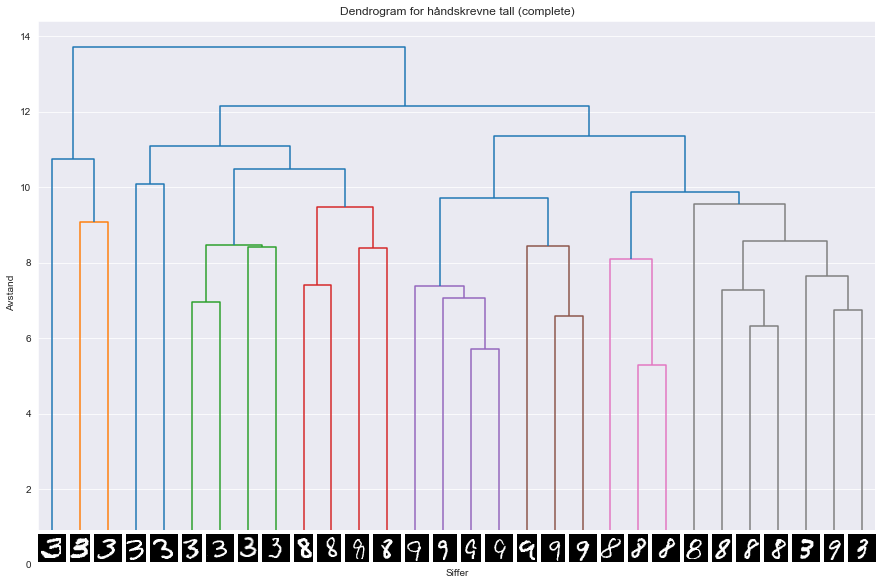

In [41]:
plt.figure(figsize=(15,10))
ax = plt.subplot()

# Bruk complete
link = linkage(y = sample, method = 'complete', metric = 'euclidean')

dendro = dendrogram(link)

dcoord = np.array(dendro["dcoord"])
icoord = np.array(dendro["icoord"])
leaves = np.array(dendro["leaves"])

idx = np.argsort(dcoord[:, 2])

dcoord = dcoord[idx, :]
icoord = icoord[idx, :]

idx = np.argsort(link[:, :2].ravel())
label_pos = icoord[:, 1:3].ravel()[idx][:n_image]

for i in range(n_image):
    imagebox = OffsetImage(sampleimg[i], cmap = 'gray', interpolation = "bilinear")
    ab = AnnotationBbox(imagebox, (label_pos[i], 0),  box_alignment=(0.5, -0.1), 
                        bboxprops={"edgecolor" : "none"})
    ax.add_artist(ab)

plt.title('Dendrogram for håndskrevne tall (complete)')
plt.xlabel('Siffer')
plt.ylabel('Avstand')
plt.xticks([])
plt.show()

ValueError: Invalid method: centriod

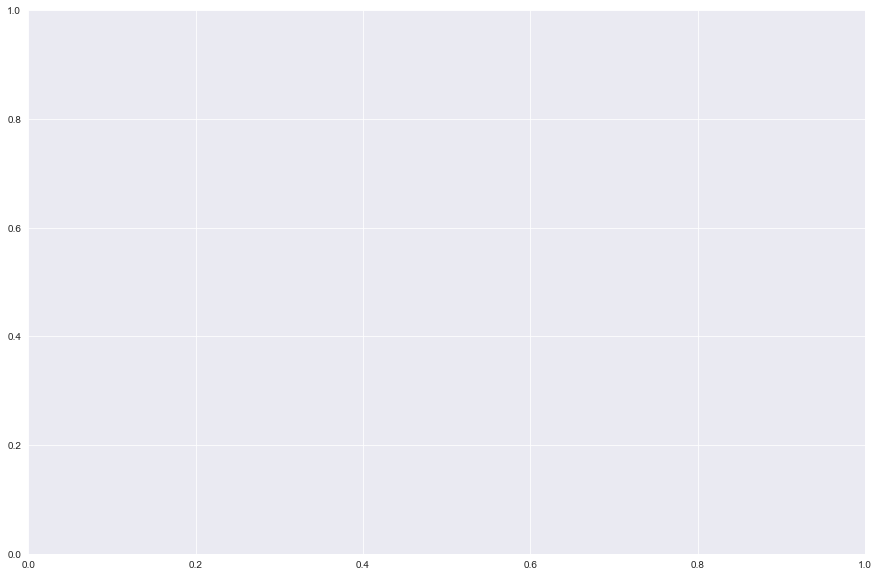

In [42]:
plt.figure(figsize=(15,10))
ax = plt.subplot()

# Bruk centriod
link = linkage(y = sample, method = 'centriod', metric = 'euclidean')

dendro = dendrogram(link)

dcoord = np.array(dendro["dcoord"])
icoord = np.array(dendro["icoord"])
leaves = np.array(dendro["leaves"])

idx = np.argsort(dcoord[:, 2])

dcoord = dcoord[idx, :]
icoord = icoord[idx, :]

idx = np.argsort(link[:, :2].ravel())
label_pos = icoord[:, 1:3].ravel()[idx][:n_image]

for i in range(n_image):
    imagebox = OffsetImage(sampleimg[i], cmap = 'gray', interpolation = "bilinear")
    ab = AnnotationBbox(imagebox, (label_pos[i], 0),  box_alignment=(0.5, -0.1), 
                        bboxprops={"edgecolor" : "none"})
    ax.add_artist(ab)

plt.title('Dendrogram for håndskrevne tall (centriod)')
plt.xlabel('Siffer')
plt.ylabel('Avstand')
plt.xticks([])
plt.show()

### Oppgave 3d) Prediksjon<a name="oppgave3d"></a>

*Oppgave 3d) inneholder 1 spørsmål du skal svare på.*

**3d.1)** Hvis vi skulle brukt en metode for å predikere/klassifisere hvilket siffer et håndskrevet tall er, og ikke bare samle dem i klynge, hva ville du brukt?

[Til toppen.](#top)